In [1]:
import json
from datetime import datetime
from urllib.request import urlopen

import numpy as np
from dateutil.rrule import rrule, DAILY
from itertools import permutations, combinations
from sklearn.preprocessing import MinMaxScaler

BET = {'3連単': ['-'.join(map(str, n)) for n in permutations(range(1, 7), 3)],
       '3連複': ['-'.join(map(str, n)) for n in combinations(range(1, 7), 3)],
       '2連単': ['-'.join(map(str, n)) for n in permutations(range(1, 7), 2)],
       '2連複': ['-'.join(map(str, n)) for n in combinations(range(1, 7), 2)],
       '単勝': ['-'.join(map(str, n)) for n in permutations(range(1, 7), 1)]}

X = []
Y = {b: [] for b in BET.keys()}

for date in rrule(DAILY, datetime(2015, 1, 1), until=datetime.today()):
#for date in rrule(DAILY, datetime(2018, 10, 1), until=datetime(2018, 10, 30)): 
    hd = date.strftime('%Y%m%d')

    data = json.loads(urlopen('http://vbetting.net/api/boatrace/data/{}'.format(hd)).read())

    for title in data['titles']:
        for race in title['races']:

            if len(race['refunds']) == 10:  # 同着が生じたレースを除外

                X.append([[c['racer_f'],
                           c['racer_l'],
                           c['racer_global_top1'],
                           c['racer_global_top2'],
                           c['racer_global_top3'],
                           c['racer_local_top1'],
                           c['racer_local_top2'],
                           c['motor_top2'],
                           c['motor_top3'],
                           c['boat_top2'],
                           c['boat_top3'],
                           ] for c in race['cards']])

                for refund in race['refunds']:
                    kind = refund['kind']

                    if kind in BET.keys():
                        Y[kind].append([refund['money'] * int(refund['perm'] == perm) / 100 for perm in BET[kind]])

X = np.array(X)
X = X.reshape((X.shape[0], -1))
X = MinMaxScaler().fit_transform(X)

KeyboardInterrupt: ignored

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model

input_ = Input(shape=X.shape[1:], name='input')
hidden = Dense(128, activation='relu', name='hidden')(input_)

bet3t = Dense(120, activation='sigmoid', name='bet3t')(hidden)
bet3f = Dense(20, activation='sigmoid', name='bet3f')(hidden)
bet2t = Dense(30, activation='sigmoid', name='bet2t')(hidden)
bet2f = Dense(15, activation='sigmoid', name='bet2f')(hidden)
bet1t = Dense(6, activation='sigmoid', name='bet1t')(hidden)

model = Model(inputs=input_, outputs=[bet3t, bet3f, bet2t, bet2f, bet1t])
plot_model(model, show_shapes=True)

In [0]:
import keras.backend as K

def loss(odds, bet):
    pay = K.sum(bet, axis=1)
    back = K.sum(odds * bet, axis=1)
    return -back / K.clip(pay, 1e-7, 1e7)

model.compile('adam', loss)

hist = model.fit(X, [*Y.values()], validation_split=0.1, epochs=100, verbose=2)

Train on 18405 samples, validate on 2046 samples
Epoch 1/100
 - 3s - loss: -3.6971e+00 - bet3t_loss: -6.8291e-01 - bet3f_loss: -7.0524e-01 - bet2t_loss: -7.1003e-01 - bet2f_loss: -7.4811e-01 - bet1t_loss: -8.5083e-01 - val_loss: -3.9664e+00 - val_bet3t_loss: -7.3906e-01 - val_bet3f_loss: -7.4261e-01 - val_bet2t_loss: -7.4552e-01 - val_bet2f_loss: -7.9460e-01 - val_bet1t_loss: -9.4456e-01
Epoch 2/100
 - 1s - loss: -4.0432e+00 - bet3t_loss: -7.7008e-01 - bet3f_loss: -7.6882e-01 - bet2t_loss: -7.8451e-01 - bet2f_loss: -8.1628e-01 - bet1t_loss: -9.0354e-01 - val_loss: -4.0676e+00 - val_bet3t_loss: -7.4298e-01 - val_bet3f_loss: -7.9485e-01 - val_bet2t_loss: -7.5410e-01 - val_bet2f_loss: -8.3049e-01 - val_bet1t_loss: -9.4515e-01
Epoch 3/100
 - 1s - loss: -4.0732e+00 - bet3t_loss: -7.8736e-01 - bet3f_loss: -7.7581e-01 - bet2t_loss: -7.8777e-01 - bet2f_loss: -8.1863e-01 - bet1t_loss: -9.0363e-01 - val_loss: -4.0671e+00 - val_bet3t_loss: -7.3813e-01 - val_bet3f_loss: -7.9814e-01 - val_bet2t_los

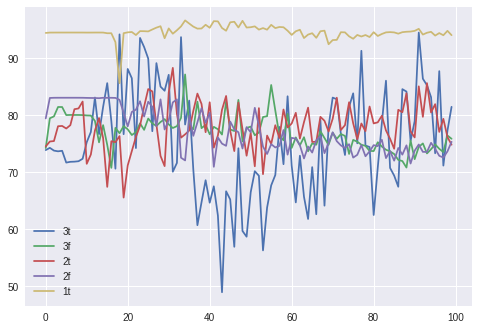

In [0]:
import matplotlib.pyplot as plt

plt.plot(-np.array(hist.history['val_bet3t_loss']) * 100, label='3t')
plt.plot(-np.array(hist.history['val_bet3f_loss']) * 100, label='3f')
plt.plot(-np.array(hist.history['val_bet2t_loss']) * 100, label='2t')
plt.plot(-np.array(hist.history['val_bet2f_loss']) * 100, label='2f')
plt.plot(-np.array(hist.history['val_bet1t_loss']) * 100, label='1t')
plt.legend()
plt.savefig('fig.png')
plt.show()